# Changing atomic data using PyNeb

It is possible to extract from the Cloudy model the electron temperature and density and the ionic fractions to re-compute at each zone of the nebula the emissivities of the lines, using the PyNeb code.
This is NOT coherent in the fact that changing the line emissivities change the cooling and then the electron temeprature. And only collisional effects are taken into account. But this can nevertheless helps to understand the effect of choosing one set of atomic data or another one in the analysis of a nebula.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
pc.config.cloudy_exe = '/usr/local/Cloudy/c17.00/source/cloudy.exe'

In [2]:
# We are using the model from the example 1
Mod = pc.CloudyModel('./model_1')

In [3]:
# Print some data about the model
Mod.print_stats()

 Name of the model: ./model_1
 R_in (cut) = 5.000e+17 (5.000e+17), R_out (cut) = 1.926e+18 (1.926e+18)
 H+ mass = 2.32e+00, H mass = 2.47e+00
 <H+/H> = 0.97, <He++/He> = 0.00, <He+/He> = 0.86
 <O+++/O> = 0.00, <O++/O> = 0.29, <O+/O> = 0.67
 <N+++/O> = 0.00, <N++/O> = 0.40, <N+/O> = 0.58
 T(O+++) = 7543, T(O++) = 7330, T(O+) = 7661
 <ne> = 104,  <nH> = 100, T0 = 7570, t2=0.0024
 <log U> = -2.79


In [5]:
# Print all the different atomic data avilable in Pyneb for the [OIII] lines
print(pn.atomicData.getAllAvailableFiles('O3',data_type='atom'))
print('--------------------------------------------------')
print(pn.atomicData.getAllAvailableFiles('O3',data_type='coll'))

['o_iii_atom.chianti', 'o_iii_atom_FFT04-SZ00.dat', 'o_iii_atom_FFT04.dat', 'o_iii_atom_GMZ97-WFD96.dat', 'o_iii_atom_SZ00-WFD96.dat']
--------------------------------------------------
['o_iii_coll.chianti', 'o_iii_coll_AK99.dat', 'o_iii_coll_LB94.dat', 'o_iii_coll_Pal12-AK99.dat', 'o_iii_coll_SSB14.dat']


(0.0, 600)

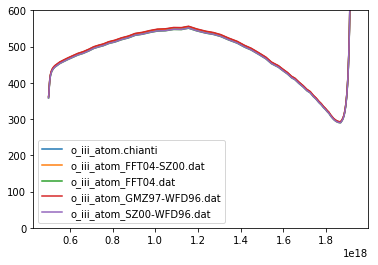

In [6]:
pc.log_.level=1
pn.log_.level=2
# Loops on the different As. 
i = 0
for O3_atom in pn.atomicData.getAllAvailableFiles('O3',data_type='atom'):
    pn.atomicData.setDataFile(O3_atom) # Change the datafile used in PyNeb
    O3 = pn.Atom('O',3)
    Mod.add_emis_from_pyneb('new_a5007_{}'.format(i), O3, wave=5007)
    Mod.add_emis_from_pyneb('new_a4363_{}'.format(i), O3, wave=4363)
    plt.plot(Mod.radius, Mod.get_emis('new_a5007_{}'.format(i))/Mod.get_emis('new_a4363_{}'.format(i)), label=O3_atom) # Plot the diagnostic ratio
    i += 1
plt.legend(loc=3)
plt.ylim((0., 600))

(0.0, 600)

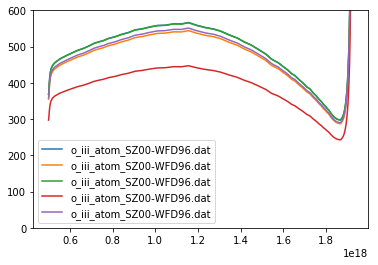

In [7]:
pc.log_.level=1
pn.log_.level=2
i = 0
# The same but changing the collision strengths
for O3_coll in pn.atomicData.getAllAvailableFiles('O3',data_type='coll'):
    pn.atomicData.setDataFile(O3_coll)
    O3 = pn.Atom('O',3)
    Mod.add_emis_from_pyneb('new_c5007_{}'.format(i), O3, wave=5007)
    Mod.add_emis_from_pyneb('new_c4363_{}'.format(i), O3, wave=4363)
    plt.plot(Mod.radius, Mod.get_emis('new_c5007_{}'.format(i))/Mod.get_emis('new_c4363_{}'.format(i)), label=O3_atom) # Plot the diagnostic ratio
    i += 1
plt.legend(loc=3)
plt.ylim((0., 600))

In [8]:
Mod.emis_labels

array(['H__1_486136A', 'H__1_656285A', 'CA_B_587564A', 'N__2_658345A',
       'O__1_630030A', 'O__2_372603A', 'O__2_372881A', 'O__3_500684A',
       'BLND_436300A', 'S__2_671644A', 'S__2_673082A', 'CL_3_551771A',
       'CL_3_553787A', 'O__1_631679M', 'O__1_145495M', 'C__2_157636M',
       'new_a5007_0', 'new_a4363_0', 'new_a5007_1', 'new_a4363_1',
       'new_a5007_2', 'new_a4363_2', 'new_a5007_3', 'new_a4363_3',
       'new_a5007_4', 'new_a4363_4', 'new_c5007_0', 'new_c4363_0',
       'new_c5007_1', 'new_c4363_1', 'new_c5007_2', 'new_c4363_2',
       'new_c5007_3', 'new_c4363_3', 'new_c5007_4', 'new_c4363_4'], 
      dtype='<U12')

In [9]:
pc.log_.level=1
pn.log_.level=2
# Define the data that will be used to compute Te
pn.atomicData.setDataFile('o_iii_coll_AK99.dat')
pn.atomicData.setDataFile('o_iii_atom_FFT04.dat')
O3 = pn.Atom('O',3)
i = 0
for O3_coll in pn.atomicData.getAllAvailableFiles('O3',data_type='coll'):
    tem_diag = Mod.get_emis_vol('new_a5007_{}'.format(i))/Mod.get_emis_vol('new_a4363_{}'.format(i))
    tem = O3.getTemDen(tem_diag, den = 1e4, wave1 = 5007, wave2 = 4363)
    print('{0:27s} [OIII]5007/4363 = {1:5.1f} Te = {2:6.1f}'.format(O3_coll, tem_diag, tem))
    i += 1
pn.atomicData.setDataFile('o_iii_coll_AK99.dat')
i = 0
for O3_atom in pn.atomicData.getAllAvailableFiles('O3',data_type='atom'):
    tem_diag = Mod.get_emis_vol('new_c5007_{}'.format(i))/Mod.get_emis_vol('new_c4363_{}'.format(i))
    tem = O3.getTemDen(tem_diag, den = 1e4, wave1 = 5007, wave2 = 4363)
    print('{0:27s} [OIII]5007/4363 = {1:5.1f} Te = {2:6.1f}'.format(O3_atom, tem_diag, tem))
    i += 1

o_iii_coll.chianti          [OIII]5007/4363 = 505.1 Te = 7244.9
o_iii_coll_AK99.dat         [OIII]5007/4363 = 505.1 Te = 7244.9
o_iii_coll_LB94.dat         [OIII]5007/4363 = 501.1 Te = 7260.5
o_iii_coll_Pal12-AK99.dat   [OIII]5007/4363 = 506.1 Te = 7243.3
o_iii_coll_SSB14.dat        [OIII]5007/4363 = 501.5 Te = 7258.0
o_iii_atom.chianti          [OIII]5007/4363 = 515.3 Te = 7214.0
o_iii_atom_FFT04-SZ00.dat   [OIII]5007/4363 = 495.6 Te = 7276.2
o_iii_atom_FFT04.dat        [OIII]5007/4363 = 514.9 Te = 7216.3
o_iii_atom_GMZ97-WFD96.dat  [OIII]5007/4363 = 408.8 Te = 7601.9
o_iii_atom_SZ00-WFD96.dat   [OIII]5007/4363 = 501.5 Te = 7258.0


In [11]:
print(pn.atomicData.getAllAvailableFiles('S2',data_type='atom'))
print('--------------------------------------------------')
print(pn.atomicData.getAllAvailableFiles('S2',data_type='coll'))

['s_ii_atom.chianti', 's_ii_atom_PKW09.dat', 's_ii_atom_TZ10-PKW09.dat', 's_ii_atom_VVF96-KHOC93.dat', 's_ii_atom_VVF96-M82a.dat']
--------------------------------------------------
['s_ii_coll.chianti', 's_ii_coll_RBS96.dat', 's_ii_coll_TZ10.dat']


(1.1, 1.4)

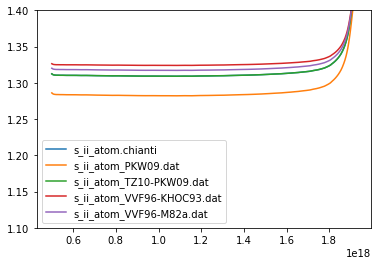

In [12]:
i = 0
for S2_atom in pn.atomicData.getAllAvailableFiles('S2',data_type='atom'):
    pn.atomicData.setDataFile(S2_atom)
    S2 = pn.Atom('S',2)
    Mod.add_emis_from_pyneb('new_a6716_{}'.format(i), S2, wave=6716)
    Mod.add_emis_from_pyneb('new_a6731_{}'.format(i), S2, wave=6731)
    plt.plot(Mod.radius, Mod.get_emis('new_a6716_{}'.format(i))/Mod.get_emis('new_a6731_{}'.format(i)), label=S2_atom)
    i += 1
plt.legend(loc=3)
plt.ylim((1.1, 1.4))

In [13]:
i = 0
for S2_atom in pn.atomicData.getAllAvailableFiles('S2',data_type='atom'):
    dens_diag = Mod.get_emis_vol('new_a6716_{}'.format(i))/Mod.get_emis_vol('new_a6731_{}'.format(i))
    dens = S2.getTemDen(dens_diag, tem=1e4, wave1=6716, wave2=6731)
    print('{0:27s} [SII]6716/31 {1:5.3f}, density = {2:5.1f}'.format(S2_atom, dens_diag, dens))
    i += 1

s_ii_atom.chianti           [SII]6716/31 1.326, density = 113.4
s_ii_atom_PKW09.dat         [SII]6716/31 1.301, density = 138.1
s_ii_atom_TZ10-PKW09.dat    [SII]6716/31 1.326, density = 113.4
s_ii_atom_VVF96-KHOC93.dat  [SII]6716/31 1.338, density =  99.5
s_ii_atom_VVF96-M82a.dat    [SII]6716/31 1.333, density = 106.4
